# a2d2 preview data explorer (Images and GPS)
- This notebooks is to explore the [A2D2]() data from Audi. Here, we explictly look for GPS and images from the front camera for preview data. 
- To be able to use this notebook, you should have downloaded the preview data from here: https://aev-autonomous-driving-dataset.s3.eu-central-1.amazonaws.com/a2d2-preview.tar and extract them. You can provide absolute or relative path in `base_dir` variable below.
- Extension to other vehicle signals should be similar to GPS and extension to other cameras should be similar to front center camera. Lidar is not considered here at all.

In [1]:
#!pip install folium matplotlib opencv-python

In [2]:
import json
import os
import cv2
import numpy as np
import re 
from datetime import datetime
import matplotlib.pyplot as plt
import folium
import pandas as pd

In [3]:
base_dir = "/Users/ikespand/Desktop/Projects/enagent/a2d2-preview/camera_lidar"  
#scene_name = "20190401_145936"  
#scene_name = "20190401_121727"  
scene_name = "20180810_150607"  

camera_name = "cam_front_center" 
bus_scene_name = scene_name.replace("_","")
bus_signals_filename = f"bus_signals_{bus_scene_name}.json"
bus_signals_path = os.path.join(base_dir, scene_name, bus_signals_filename)
take_every_nth_frame = 7
image_dir = os.path.join(base_dir, scene_name, "camera", camera_name)
print(f"Images will be from: {image_dir}")
print(f"Bus signals will be from: {bus_signals_filename}")

Images will be from: /Users/ikespand/Desktop/Projects/enagent/a2d2-preview/camera_lidar/20180810_150607/camera/cam_front_center
Bus signals will be from: bus_signals_20180810150607.json


In [4]:
# Get all lat and lon from the JSON of vehicle's bus data along with timestamps in 3 different lists
with open(bus_signals_path, 'r') as f:
    bus_signals_data = json.load(f)

if "latitude_degree" in bus_signals_data and "longitude_degree" in bus_signals_data:
    latitude_data = bus_signals_data["latitude_degree"]["values"]
    longitude_data = bus_signals_data["longitude_degree"]["values"]

    timestamps_gps = []
    latitudes = []
    longitudes = []

    for lat_entry, lon_entry in zip(latitude_data, longitude_data):
        timestamp_lat, latitude = lat_entry
        timestamp_lon, longitude = lon_entry
        if timestamp_lat != timestamp_lon:
            raise ValueError("Timestamps for latitude and longitude do not match")
        timestamps_gps.append(timestamp_lat)
        latitudes.append(latitude)
        longitudes.append(longitude)

In [5]:
# Get the list of PNG files and sort them by frame ID. Finally filter every nth frame to avoir near-duplicate frames
png_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
png_files.sort(key=lambda filename: int(re.search(r"_(\d+)\.png", filename).group(1)))
png_files = png_files[::take_every_nth_frame] # Take every nth frame

Image: 20180810150607_camera_frontcenter_000000083.png, Timestamp: 1533906415488833, Nearest GPS Timestamp: 1533906415518886, Lat: 48.788047, Lon: 11.382496
image_timestamp_ns (readable): 2018-08-10 15:06:55
nearest_gps_timestamp (readable): 2018-08-10 15:06:55


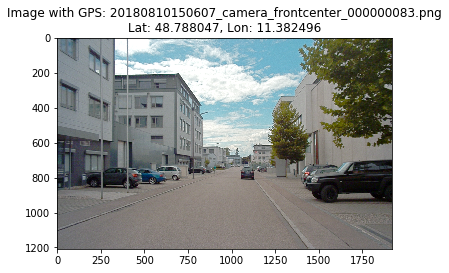

Image: 20180810150607_camera_frontcenter_000000090.png, Timestamp: 1533906415722186, Nearest GPS Timestamp: 1533906415678893, Lat: 48.788047, Lon: 11.382496
image_timestamp_ns (readable): 2018-08-10 15:06:55
nearest_gps_timestamp (readable): 2018-08-10 15:06:55


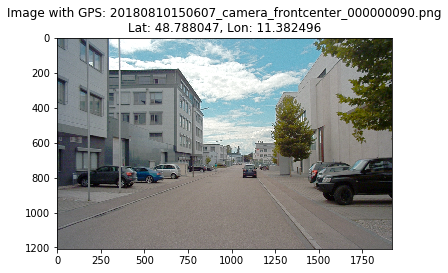

Image: 20180810150607_camera_frontcenter_000000097.png, Timestamp: 1533906415955536, Nearest GPS Timestamp: 1533906415998902, Lat: 48.788047, Lon: 11.382496
image_timestamp_ns (readable): 2018-08-10 15:06:55
nearest_gps_timestamp (readable): 2018-08-10 15:06:55


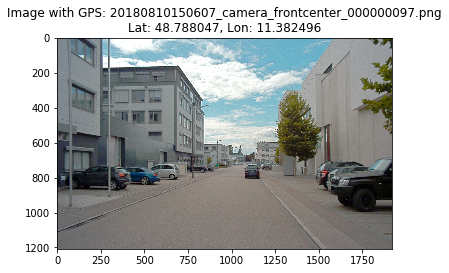

Image: 20180810150607_camera_frontcenter_000000104.png, Timestamp: 1533906416188860, Nearest GPS Timestamp: 1533906416158905, Lat: 48.788047, Lon: 11.382496
image_timestamp_ns (readable): 2018-08-10 15:06:56
nearest_gps_timestamp (readable): 2018-08-10 15:06:56


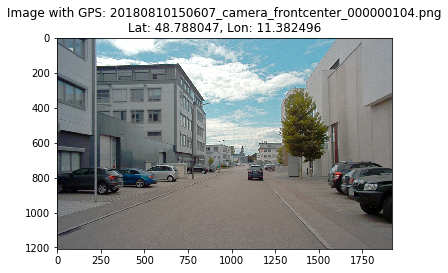

Image: 20180810150607_camera_frontcenter_000000111.png, Timestamp: 1533906416422211, Nearest GPS Timestamp: 1533906416478912, Lat: 48.788043, Lon: 11.38243
image_timestamp_ns (readable): 2018-08-10 15:06:56
nearest_gps_timestamp (readable): 2018-08-10 15:06:56


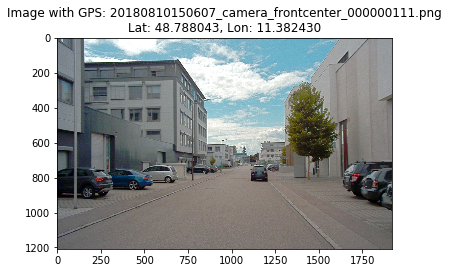

Image: 20180810150607_camera_frontcenter_000000118.png, Timestamp: 1533906416655572, Nearest GPS Timestamp: 1533906416798920, Lat: 48.788043, Lon: 11.38243
image_timestamp_ns (readable): 2018-08-10 15:06:56
nearest_gps_timestamp (readable): 2018-08-10 15:06:56


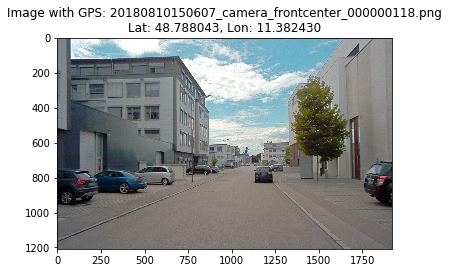

In [6]:
nearest_latitudes = []
nearest_longitudes = []
nearest_gps_timestamps = []
image_timestamps = []
image_paths = []

for filename in png_files:
    if filename.endswith(".png"):
        image_path = os.path.join(image_dir, filename)
        json_filename = filename[:-4] + ".json"  # Replace .png with .json
        json_path = os.path.join(image_dir, json_filename)
        try:
            with open(json_path, 'r') as f:
                image_data = json.load(f)
                image_timestamp_ns = image_data["cam_tstamp"] # Get timestamp from json
                camera_name_from_file = image_data["cam_name"]
                # Extract frame ID from filename (for display, etc.)
                match = re.search(r"_(\d+)\.png", filename)
                if match:
                    frame_id = int(match.group(1))
                else:
                    frame_id = None  # Handle cases where frame ID can't be extracted
        except FileNotFoundError:
            print(f"JSON file not found: {json_path}")
            continue  # Skip to the next image if JSON is missing
        except json.JSONDecodeError:
            print(f"Error decoding JSON: {json_path}")
            continue
                
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error reading image: {image_path}")
            continue

        # Convert BGR to RGB for Matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Find nearest GPS timestamp
        nearest_gps_index = np.argmin(np.abs(np.array(timestamps_gps) - image_timestamp_ns))
        nearest_gps_timestamp = timestamps_gps[nearest_gps_index]
        nearest_latitude = latitudes[nearest_gps_index]
        nearest_longitude = longitudes[nearest_gps_index]
        nearest_latitudes.append(nearest_latitude)
        nearest_longitudes.append(nearest_longitude)
        nearest_gps_timestamps.append(nearest_gps_timestamp)
        image_timestamps.append(image_timestamp_ns)
        image_paths.append(image_path)

        # Now you have the image 'img' and its nearest GPS coordinates
        print(f"Image: {filename}, Timestamp: {image_timestamp_ns}, Nearest GPS Timestamp: {nearest_gps_timestamp}, Lat: {nearest_latitude}, Lon: {nearest_longitude}")
        print(f"image_timestamp_ns (readable): {datetime.fromtimestamp(image_timestamp_ns / 1e6).strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"nearest_gps_timestamp (readable): {datetime.fromtimestamp(nearest_gps_timestamp / 1e6).strftime('%Y-%m-%d %H:%M:%S')}")
        # Display the image
        plt.imshow(img_rgb)  # Use the RGB image
        plt.title(f"Image with GPS: {filename}\nLat: {nearest_latitude:.6f}, Lon: {nearest_longitude:.6f}")
        plt.show()

In [7]:
nearest_latitudes.append(nearest_latitude)
nearest_longitudes.append(nearest_longitude)
nearest_gps_timestamps.append(nearest_gps_timestamp)
image_timestamps.append(image_timestamp_ns)
image_paths.append(image_path)

df = pd.DataFrame({
    'lat': nearest_latitudes,
    'lon': nearest_longitudes,
    'img_timestamp': image_timestamps,
    'gps_timestamp': nearest_gps_timestamps,
    'img_path': image_paths
})
df.head(5)

,lat,lon,img_timestamp,gps_timestamp,img_path
0,48.788047,11.382496,1533906415488833,1533906415518886,/Users/ikespand/Desktop/Projects/enagent/a2d2-...
1,48.788047,11.382496,1533906415722186,1533906415678893,/Users/ikespand/Desktop/Projects/enagent/a2d2-...
2,48.788047,11.382496,1533906415955536,1533906415998902,/Users/ikespand/Desktop/Projects/enagent/a2d2-...
3,48.788047,11.382496,1533906416188860,1533906416158905,/Users/ikespand/Desktop/Projects/enagent/a2d2-...
4,48.788043,11.382430,1533906416422211,1533906416478912,/Users/ikespand/Desktop/Projects/enagent/a2d2-...


In [8]:
def plot_lat_lon_with_tooltip(df:pd.DataFrame(), zoom_level:int=22):
    """Plots df with lat and lon on the map with some tooltips with other column(s)"""
    # Calculate the center of the map (you can adjust this)
    center_lat = df['lat'].mean()
    center_lon = df['lon'].mean()

    # Create a map centered at the calculated coordinates
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom_level)

    # Add markers with tooltips
    for index, row in df.iterrows():
        folium.Marker(
            location=[row['lat'], row['lon']],
            tooltip=f"Timestamp: {row['img_timestamp']}<br>Path: {row['img_path']}"
        ).add_to(m)

    # Display the map in the notebook
    return m  # Return the map object so it can be displayed in the notebook

map_object = plot_lat_lon_with_tooltip(df)
map_object  

# Uncomment following to save HTML map file locally
# map_object.save("map.html")  

In [9]:
df.to_csv(f"{scene_name}.csv", index=False)